Environment setup

In [ ]:
#%pip install transformers
#%pip install datasets
#%pip install grad-cam

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from transformers import ViTForImageClassification
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import List, Callable, Optional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
colab_data_path = "/content/drive/MyDrive/ribe_512x768/"
colab_dir = "/content/drive/MyDrive/Seminar2/model/checkpoint-900/"
model_name_or_path = "google/vit-base-patch16-224-in21k"

Model wrapper to return a tensor.

In [5]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

Translate the category name to the category index.

In [6]:
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

Helper function to run GradCAM on an image and create a visualization.

In [7]:
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook.
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

Helper function to print top predicted categories.

In [8]:
def print_top_categories(model, img_tensor, top_k=1):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

Helper function to reshape the activations from the ViT model.

In [9]:
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.reshape(activations.shape[0],
                                   32, 48, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

Load the model and set up the GradCam parameters.

In [10]:
model = ViTForImageClassification.from_pretrained(colab_dir)  # Load the pre-trained Vision Transformer model.
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "divlje")), ClassifierOutputTarget(category_name_to_index(model, "tunakavez")),
                       ClassifierOutputTarget(category_name_to_index(model, "uzgoj"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output

## Example showing a correctly classified image

Class: divlje

In [11]:
image1_path = colab_data_path + "test/divlje/divlje_test_2020_WS_001.JPG"
image1 = Image.open(image1_path)
image1_tensor = transforms.ToTensor()(image1)

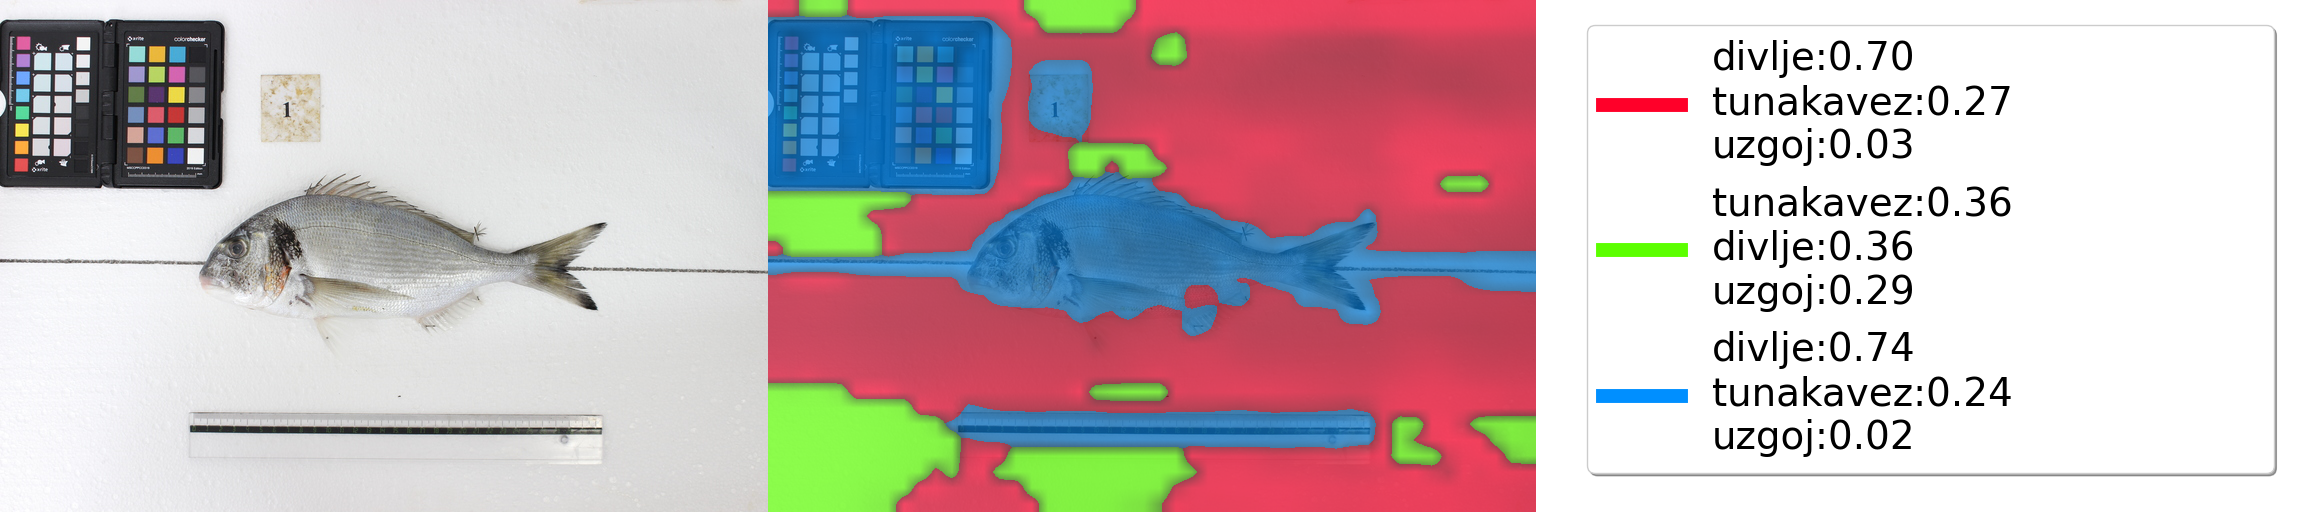

In [12]:
display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image1,
                          img_tensor=image1_tensor,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=3,
                          top_k=3)))

Heatmaps for each category: in order - divlje, tunakavez, uzgoj.

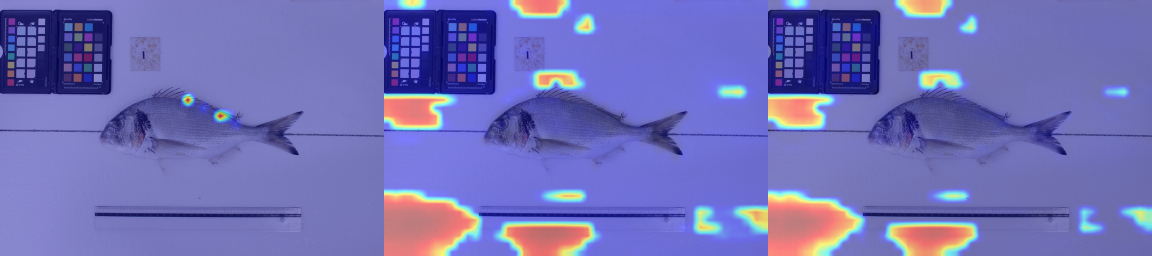

In [13]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=image1_tensor,
                      input_image=image1,
                      reshape_transform=reshape_transform_vit_huggingface)))

In [14]:
print_top_categories(model, image1_tensor)

Predicted class 0: divlje


## Problematic images

Class: uzgoj

In [17]:
image2_path = colab_data_path + "test/uzgoj/uzgoj_test_O15VS14_16.JPG"
image2 = Image.open(image2_path)
image2_tensor = transforms.ToTensor()(image2)

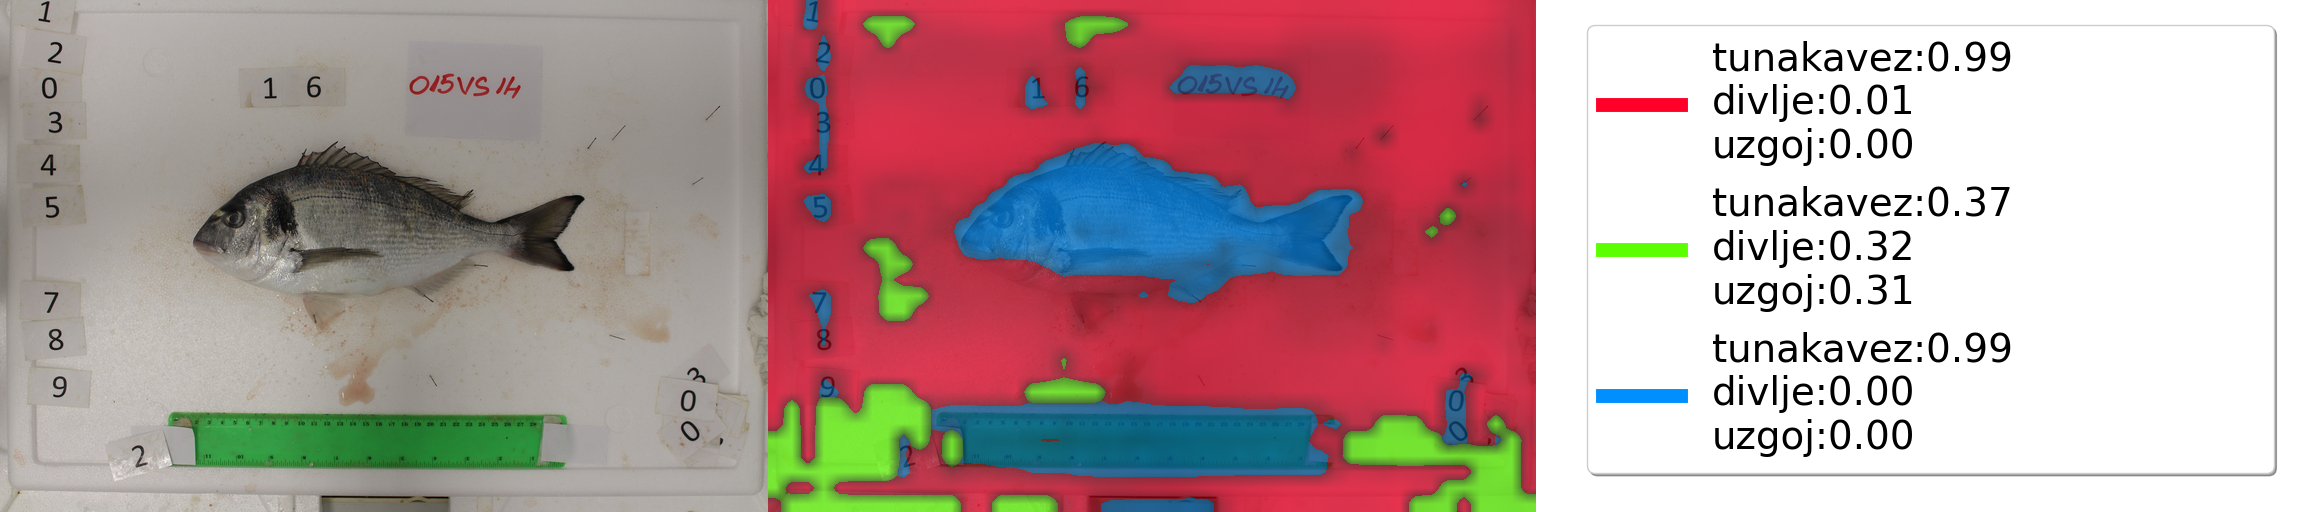

In [19]:
display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image2,
                          img_tensor=image2_tensor,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=3,
                          top_k=3)))

Heatmaps for each category: in order - divlje, tunakavez, uzgoj.

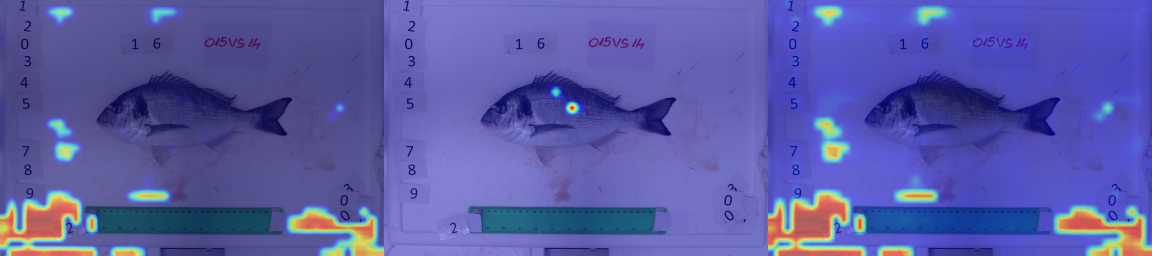

In [20]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=image2_tensor,
                      input_image=image2,
                      reshape_transform=reshape_transform_vit_huggingface)))

In [21]:
print_top_categories(model, image2_tensor)

Predicted class 1: tunakavez
